In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as patheffects
from typing import List, Tuple, Union, Callable
import qutip as qu
from scipy import linalg
import warnings

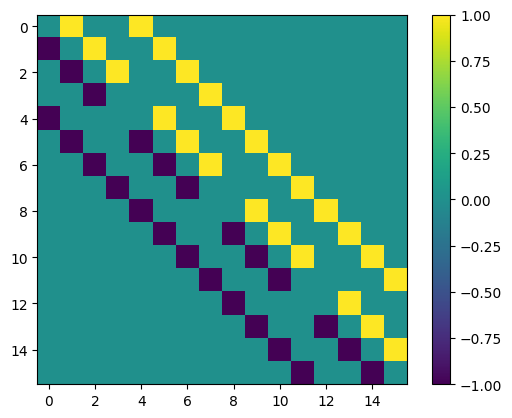

In [4]:
def create_square_lattice_hamiltonian(L: int, t: complex) -> np.ndarray:
    x_hop = np.tile([t] * (L - 1) + [0], L)[:-1]
    y_hop = np.array([t] * L * (L - 1))

    H = np.diag(x_hop, 1) + np.diag(y_hop, L)
    return H + H.conj().T

def erase_to_brickwall_lattice(H: np.ndarray) -> np.ndarray:
    L = int(np.sqrt(H.shape[0]))
    if L % 2 == 0:
        y_hop_row = np.tile([0, 1], L//2)
        y_hop = np.concatenate([y_hop_row, 1 - y_hop_row] * (L // 2 - 1) + [y_hop_row])
    else:
        y_hop = np.tile([0, 1], L*(L-1)//2)
    
    erase_positions = np.diag(y_hop, L) + np.diag(y_hop, -L)
    H *= (1-erase_positions)
    return H

plt.imshow((create_square_lattice_hamiltonian(L=4, t=1j).imag))
plt.colorbar()
plt.show()

In [132]:
class SquareLattice:
    def __init__(self, L:int, t_hop:float, E_amplitude: Union[float, Callable[[float], float]], E_dir:np.ndarray, h: float, steps: int, initial_occupation: float=None):
        if L%2:
            warnings.warn("Lattice size L should be even - then a whole number of states can be excited with half occupation.", category=UserWarning)
        self.L = L
        self.t_hop = t_hop
        self.t = 0 # time

        if(callable(E_amplitude)):
            self.E = E_amplitude
        else:
            self.E = lambda _: E_amplitude
        self.E_dir = E_dir
        
        print("Creating Hamiltonians...")
        self.H_onsite = self.create_onsite_potentials()
        self.H_hop = self.create_hopping_hamiltonian()
        print("Done.")

        self.density_matrix = np.zeros((self.L**2, self.L**2))

        self.states = None
        
        self.h = h
        self.steps = steps 

        print("Calculating energy eigenstates...")
        self.eigen_energies, self.energy_states = linalg.eigh(self.H_hop)
        print("Done.")

        if initial_occupation:
            self.set_fractional_occupation(initial_occupation)
            print(f"{100 * initial_occupation:.0f} % of states were set as initially occupied.")


    def create_hopping_hamiltonian(self) -> np.ndarray:
        x_hop = np.tile([self.t_hop] * (self.L - 1) + [0], self.L)[:-1]
        y_hop = np.array([self.t_hop] * self.L * (self.L - 1))

        H = np.diag(x_hop, 1) + np.diag(y_hop, self.L)
        return H + H.conj().T


    def create_onsite_potentials(self) -> np.ndarray:
        potentials = [-np.dot([i, j], self.E_dir) for i in range(self.L) for j in range(self.L)] #- E . r
        potentials -= np.mean(potentials) # center around 0
        return np.diag(potentials)


    @property
    def H(self):
        return self.H_hop + self.E(self.t)*self.H_onsite
    

    def plot_hamiltonian(self) -> None:
        """
        Visualizes a Hamiltonian H (of size L^2 x L^2) as a square lattice.
        
        Each node at grid position (i, j) represents the diagonal element
        H[L*i + j, L*i + j]. Off-diagonal nonzero elements H[u,v] (u < v)
        are drawn as lines connecting the corresponding nodes, with the value
        of H[u,v] printed at the midpoint.
        
        Parameters:
            H : 2D numpy array of shape (L^2, L^2)
        """
        L = int(np.sqrt(self.H.shape[0]))

        # Dictionary to store positions of each node.
        positions = {}
        for i in range(L):
            for j in range(L):
                idx = L * i + j
                # Set node positions: x coordinate is j, y coordinate is -i (so row 0 is top)
                positions[idx] = (j, -i)
        
        # Create plot
        fig, ax = plt.subplots(figsize=(2*L, 2*L))

        norm = plt.Normalize(vmin=self.H.diagonal().min(), vmax=self.H.diagonal().max())
        cmap = plt.get_cmap('inferno')

        # Plot nodes with their diagonal values.
        for idx, (x, y) in positions.items():
            diag_val = self.H[idx, idx]
            color_val = complex(norm(diag_val)).real
            circle_color = cmap(color_val)
            circle = plt.Circle((x, y), 0.3, color=circle_color, zorder=2)
            ax.add_patch(circle)
            # Add text with shadow for better contrast
            

            ax.text(x, y, f"{diag_val:.10f}", color='white', ha='center', va='center', fontsize=10, zorder=3,
                        path_effects=[patheffects.withStroke(linewidth=1, foreground='black')])
        
        
        # Plot edges for off-diagonal nonzero elements.
        # To avoid drawing each edge twice, we loop only over pairs with u < v.
        for u in range(L * L):
            for v in range(u + 1, L * L):
                if self.H[u, v] != 0:
                    x1, y1 = positions[u]
                    x2, y2 = positions[v]
                    # Draw a line connecting the two nodes.
                    ax.plot([x1, x2], [y1, y2], 'r-', linewidth=1, zorder=1)
                    # Compute the midpoint of the edge.
                    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
                    # Place the value of H[u,v] near the midpoint.
                    ax.text(xm, ym+0.1, f"{self.H[u, v]:.1f}", color='red', ha='center', va='center',
                            fontsize=8, zorder=4)
        
        # Set plot parameters.
        ax.set_aspect('equal')
        ax.axis('off')
        plt.show()

        # Imshow real and imag part of H
        fig, (ax1, ax2) = plt.subplots(1, 2)

        im1 = ax1.imshow(self.H.real)
        ax1.set_title('$\\Re (H)$')
        fig.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(self.H.imag)
        ax2.set_title('$\\Im (H)$')
        fig.colorbar(im2, ax=ax2)

        plt.show()


    def set_fractional_occupation(self, occupation_fraction=0.5) -> None:
        rho_energy_basis = np.diag([1 if i/self.L**2 < occupation_fraction else 0 for i in range(self.L**2)])
        self.density_matrix = 1/(occupation_fraction * self.L**2) * self.energy_states @ rho_energy_basis @ self.energy_states.T.conj()


    def evolve(self, force_reevolve=False) -> None:
        if self.states is not None and not force_reevolve:
            print("Lattice was already evolved, call with force_reevolve=True to simulate again.")
            return
        H = [qu.Qobj(self.H_hop), [qu.Qobj(self.H_onsite), self.E]]
        rho = qu.Qobj(self.density_matrix)
        step_list = np.linspace(0, self.h*self.steps, self.steps)
        sim = qu.mesolve(H, rho, step_list)

        self.states = list(map(lambda qu_state: qu_state.data_as(format="ndarray"), sim.states))


    def animate_current_density(self, filename: str, fps:int=10, sample_every:int=1) -> None:
        fig, ax = plt.subplots()
        animation = matplotlib.animation.FuncAnimation(fig, lambda frame: self.plot_current_density(sample_every*frame, ax), frames=len(self.states)//sample_every)
        animation.save(filename, writer="imagemagick", fps=fps)

    def plot_state(self):
        self.plot_current_density(0)

    def plot_current_density(self, state_index: int, ax: matplotlib.axes = None):
        show_plot = ax is None

        if self.states is None:
            if state_index > 0:
                print("Lattice was not evolved, call evolve() before plotting.")
                return
            state_matrix = self.density_matrix
        else:
            state_matrix = self.states[state_index]
        
        current_matrix = (self.H_hop * state_matrix.T).imag

        if ax is None:
            _, ax = plt.subplots(figsize=(2*self.L, 2*self.L))
        else:
            ax.clear()
            #ax.set_xlim(2*self.L)
            #ax.set_ylim(2*self.L)
    
        positions = {(i, j): (j, -i) for i in range(self.L) for j in range(self.L)}
    
        # Normalize node colors based on diagonal values
        diag_values = np.real(np.diag(state_matrix))
        norm = plt.Normalize(vmin=diag_values.min(), vmax=diag_values.max())
        cmap = plt.get_cmap('Greys_r').reversed()
        
        # Plot nodes
        for (i, j), (x, y) in positions.items():
            idx = self.L * i + j
            color_val = cmap(norm(diag_values[idx]))
            circle = plt.Circle((x, y), 0.3, facecolor=color_val, zorder=2, edgecolor="black")
            ax.add_patch(circle)
            ax.text(x, y, f"{diag_values[idx]:.2f}", color='white', ha='center', va='center', fontsize=10,
                    path_effects=[patheffects.withStroke(linewidth=1, foreground='black')])
        
        # Normalize current values for thickness
        abs_current = np.abs(current_matrix)
        max_current = np.max(abs_current) if np.max(abs_current) > 0 else 1
        
        # Plot currents as lines between nodes
        for u in range(self.L * self.L):
            for v in range(u + 1, self.L * self.L):
                if self.H_hop[u, v] != 0:
                    x1, y1 = positions[u // self.L, u % self.L]
                    x2, y2 = positions[v // self.L, v % self.L]
                    
                    current_val = current_matrix[u, v]

                    linewidth = 3 * abs(current_val) / max_current  # Scale line thickness
                    color = 'blue' if current_val > 0 else 'red'
                    
                    xval = np.linspace(x1, x2, 8)
                    yval = np.linspace(y1, y2, 8)

                    if x1 == x2:
                        arrow = "v" if current_val<0 else "^"
                    else:
                        arrow = ">" if current_val < 0 else "<"

                    ax.plot(xval, yval, "-", linewidth=min(50, 5*linewidth), color=color, alpha=0.2, zorder=1)
                    ax.plot(xval, yval, arrow, linewidth=linewidth, color=color, alpha=min(1, 5*linewidth), markersize=(5+4*linewidth**0.5), zorder=0)
        

        circle = plt.Circle((self.L+1, 0), 0, facecolor="red")
        ax.add_patch(circle)
        arrow_x, arrow_y = self.L-0.1, -1 # Position outside grid

        Emax = max([np.abs(self.E(i*self.h)) for i in range(self.steps)])

        Ey, Ex = 1/Emax * self.E(state_index * self.h) * self.E_dir  # Extract components

        ax.annotate("", xy=(arrow_x + Ex, arrow_y - Ey), xytext=(arrow_x, arrow_y),
            arrowprops=dict(arrowstyle="->", color="black", lw=4))
        ax.text(arrow_x + 0.2, arrow_y, "$E$", fontsize=14, color='black')
        ax.set_aspect('equal')
        ax.axis('off')
        
        if show_plot or True: 
            plt.show()


    def curl(self, ij):
        pass

In [134]:
class BrickwallLattice(SquareLattice):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


    def get_brickwall_lattice_sites(self) -> np.ndarray:
        if self.L % 2 == 0:
            y_hop_row = np.tile([0, 1], self.L//2)
            y_hop = np.concatenate([y_hop_row, 1 - y_hop_row] * (self.L // 2 - 1) + [y_hop_row])
        else:
            y_hop = np.tile([0, 1], self.L*(self.L-1)//2)
        
        erase_positions = np.diag(y_hop, self.L) + np.diag(y_hop, -self.L)
        return 1-erase_positions
    
    
    def create_hopping_hamiltonian(self):
        return super().create_hopping_hamiltonian() * self.get_brickwall_lattice_sites()

/tmp/ipykernel_7104/3687966513.py:4: UserWarning: Lattice size L should be even - then a whole number of states can be excited with half occupation.
  warnings.warn("Lattice size L should be even - then a whole number of states can be excited with half occupation.", category=UserWarning)


Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.
50 % of states were set as initially occupied.


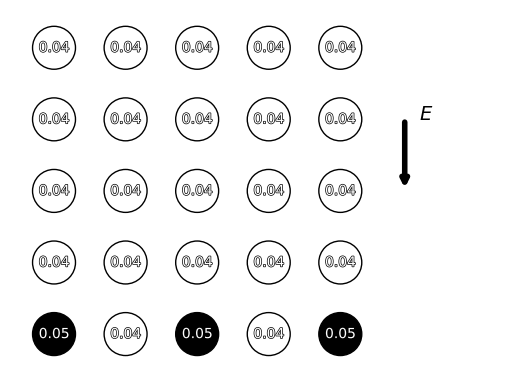

In [135]:
bw = BrickwallLattice(L=5, t_hop=1, E_amplitude=.00000001, E_dir=np.array([1, 0]), h=1e-4, steps=7_000, initial_occupation=0.5)
bw.evolve()
bw.animate_current_density("bw_const.gif", fps=30, sample_every=31)

Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.


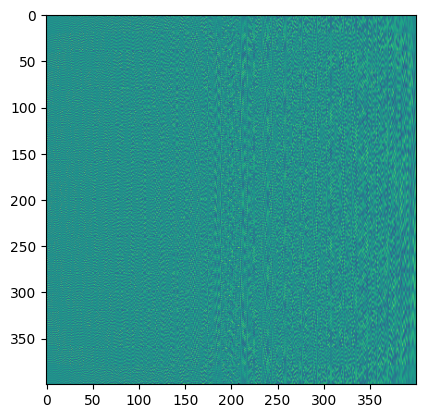

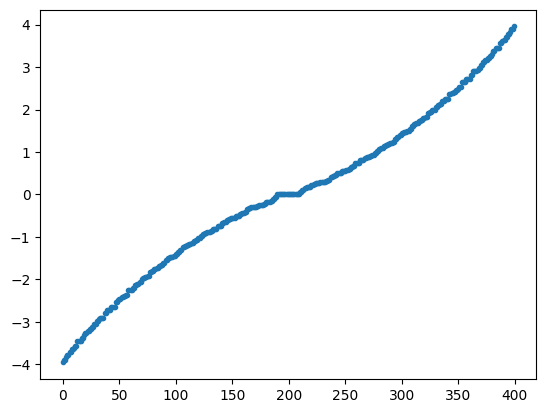

In [55]:
sq2 = SquareLattice(L=20, t_hop=1, E_amplitude=1, E_dir=[1, 0], h=1, steps=10)
energies, eigenstates = linalg.eigh(sq2.H_hop)
plt.imshow(eigenstates)
plt.show()
plt.plot(energies, ".")
plt.show()

In [9]:
class BrickwallLattice(SquareLattice):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_brickwall_sites(self) -> np.ndarray:
        if self.L % 2 == 0:
            y_hop_row = np.tile([0, 1], self.L//2)
            y_hop = np.concatenate([y_hop_row, 1 - y_hop_row] * (self.L // 2 - 1) + [y_hop_row])
        else:
            y_hop = np.tile([0, 1], self.L*(self.L-1)//2)
        
        erase_positions = np.diag(y_hop, self.L) + np.diag(y_hop, -self.L)
        return 1-erase_positions
    
    def create_hopping_hamiltonian(self):
        return super().create_hopping_hamiltonian() * self.get_brickwall_sites()

Lattice was already evolved, call with force_reevolve=True to simulate again.


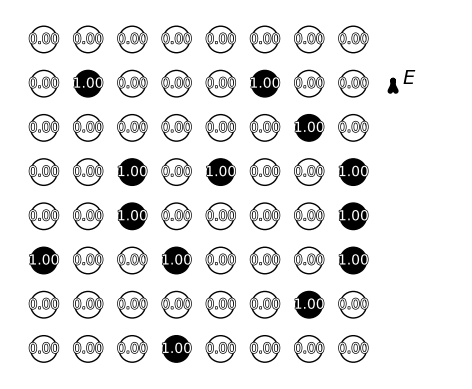

In [14]:
#sq = SquareLattice(8, 1, lambda t: .1, np.array([1, 0]), h=1e-3, steps=5_000)
#sq.set_fractional_occupation(0.2)
#sq.plot_hamiltonian()

sq.evolve()
sq.animate_current_density("sq cos constant 8x8.gif", fps=10, sample_every=50)

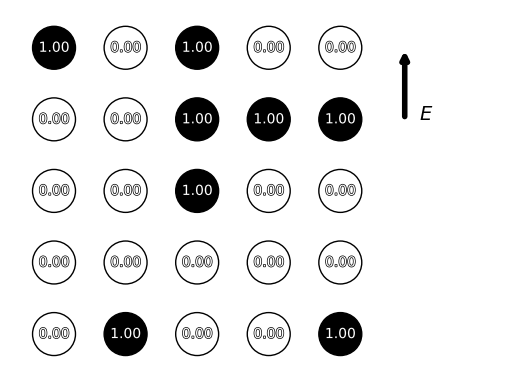

In [102]:
bw = BrickwallLattice(5, 1, lambda t: np.cos(t), np.array([1, 0]), h=1e-3, steps=5000)
bw.set_fractional_occupation(0.3)
bw.evolve()
bw.animate_current_density("bw cos.gif", fps=10, sample_every=50)